          ┌───┐┌───┐                               ┌───┐┌───────────────┐┌───┐»
s_0: ─────┤ X ├┤ H ├───────■────────────────────■──┤ H ├┤ Rz(0.2*$t_0$) ├┤ H ├»
          └─┬─┘├───┤┌───┐┌─┴─┐┌──────────────┐┌─┴─┐├───┤├───────────────┤├───┤»
s_1: ───────┼──┤ Y ├┤ H ├┤ X ├┤ Rz(-$t_0$/5) ├┤ X ├┤ H ├┤ Rz(0.2*$t_0$) ├┤ H ├»
     ┌───┐  │  └─┬─┘└───┘└───┘└──────────────┘└───┘└───┘└───────────────┘└───┘»
  a: ┤ H ├──■────■────────────────────────────────────────────────────────────»
     └───┘                                                                    »
«                               ┌───┐┌───┐                          ┌───┐»
«s_0: ──■────────────────────■──┤ H ├┤ H ├──■────────────────────■──┤ H ├»
«     ┌─┴─┐┌──────────────┐┌─┴─┐├───┤├───┤┌─┴─┐┌──────────────┐┌─┴─┐├───┤»
«s_1: ┤ X ├┤ Rz(-$t_0$/5) ├┤ X ├┤ H ├┤ H ├┤ X ├┤ Rz(-$t_0$/5) ├┤ X ├┤ H ├»
«     └───┘└──────────────┘└───┘└───┘└───┘└───┘└──────────────┘└───┘└───┘»
«  a: ───────────────────────────────────────────────────────────

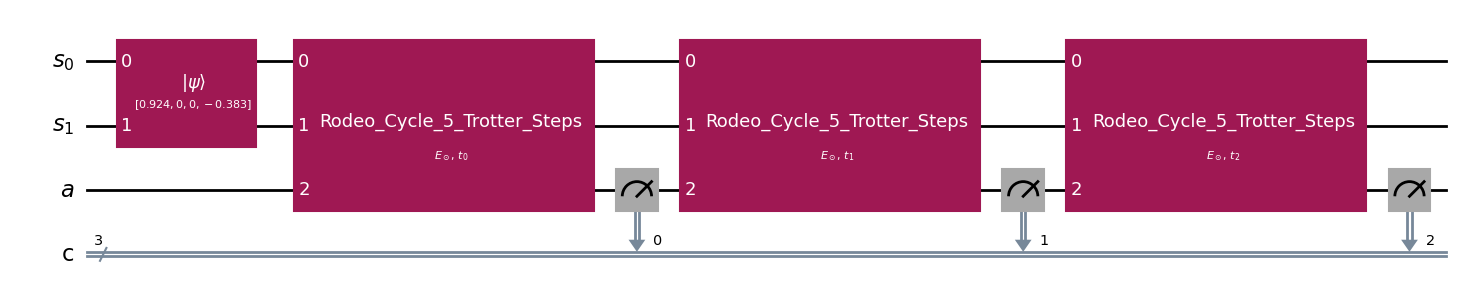

In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter, Gate
from qiskit_aer.primitives import Sampler

def XX_interaction(N, M, beta, cxx, qc):
    # Horizontal interactions
    for row in range(N):
        for col in range(M - 1):
            i = row * M + col
            qc.h(i)
            qc.h(i + 1)
            qc.cx(i, i + 1)
            qc.rz(cxx * beta, i + 1)
            qc.cx(i, i + 1)
            qc.h(i)
            qc.h(i + 1)

    """
    # Vertical interactions
    for row in range(N - 1):
        for col in range(M):
            i = row * M + col
            qc.cx(i, i + M)
            qc.rz(cxx * beta, i + M)
            qc.cx(i, i + M)
            qc.h(i)
            qc.h(i + M)
    """

# Transverse magnetic field
def magn_interaction(N, M, beta, hz, qc):
    for i in range(N * M):
        qc.rz(2 * hz * beta, i) # Factor of 2 since that is how we defined the Second-Order Trotterization

def rodeo_cycle(N, M, t: Parameter, r, cxx, cyy, hz, targ: Parameter):
    beta = t / r # Parameter for rotation gates
    sys = QuantumRegister(N * M, 's')
    aux = QuantumRegister(1, 'a')
    qc = QuantumCircuit(sys, aux)

    # Initialize ancilla qubit to be in superposition
    qc.h(aux[0])

    # Add Y reversal gates to odd, X reversal gates to even qubits
    for row in range(N):
        for col in range(M):
            idx = row * M + col
            if (row + col) % 2 == 0:
                qc.cx(aux[0], sys[idx])
            else:
                qc.cy(aux[0], sys[idx])

    # Trotter time evolution
    for _ in range(r):
        XX_interaction(N, M, beta, cxx, qc)
        magn_interaction(N, M, beta, hz, qc)
        XX_interaction(N, M, beta, cxx, qc)

    # Add reversal gates at end
    for row in range(N):
        for col in range(M):
            idx = row * M + col
            if (row + col) % 2 == 0:
                qc.cx(aux[0], sys[idx])
            else:
                qc.cy(aux[0], sys[idx])
                
    # Add phase gate to ancilla
    qc.p(2*targ * t, aux[0])

    # Revert superposition
    qc.h(aux[0])
    print(qc)
    return qc.to_gate(label=f"Rodeo_Cycle_{r}_Trotter_Steps")

# Parameters
N = 1
M = 2
cxx = -1 #0.5 * 0.2 * np.pi
cyy = 0 #0.5 * 0.2 * np.pi
hz = 0.5
numqubits = N * M
cycles = 3

# Initialize system parameters
sysqubits = 1
timeresamples = 10

# Create Target and t parameters
targ = Parameter(r'$E_\odot$')
t = [Parameter(fr'$t_{i}$') for i in range(cycles)]
r = 5

# Create a list of target energies at the same length of the cycle
targ_list = [targ] * cycles

# Create registers and circuit
classical = ClassicalRegister(cycles, 'c')
aux = QuantumRegister(1, 'a')
sys = QuantumRegister(numqubits, 's')
circuit = QuantumCircuit(classical, sys, aux)

i_state = np.array([0.92387953,0,0,-0.38268343])
i_state = i_state/np.linalg.norm(i_state)
circuit.initialize(i_state, [0,1])

# Create circuit
for j in range(cycles):
    circuit.append(rodeo_cycle(N, M, t[j], r, cxx, cyy, hz, targ_list[j]), range(1 + numqubits))
    circuit.measure(aux, classical[j])

circuit.draw(output='mpl')


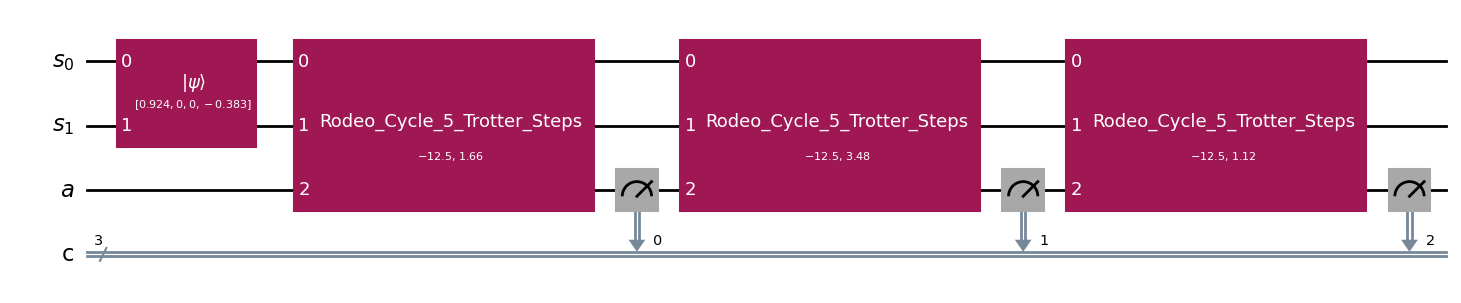

In [2]:
gamma = 1/2
for _ in range(timeresamples):
    tsamples = ((1 / gamma) * np.abs(np.random.randn(cycles))).tolist()
    #parameter_binds.append({t[i]: tsamples[i] for i in range(cycles)})
    
parameter_binds = zip(t, tsamples)
parameters = dict(parameter_binds)

target = {targ : -12.5}
    
circuit1 = circuit.assign_parameters(parameters, inplace =False)
circuit2 = circuit1.assign_parameters(target, inplace = False)
circuit2.draw(output= 'mpl')

In [3]:
sampler = Sampler()

job = sampler.run(circuit2)

job.result()

quasi_dists = job.result().quasi_dists

print(quasi_dists)

[{4: 0.0029296875, 5: 0.001953125, 7: 0.0205078125, 1: 0.150390625, 6: 0.6591796875, 2: 0.013671875, 0: 0.1513671875}]


In [4]:
# Enumerate scan energies
energymin = -2
energymax = 2
stepsize = 0.05

targetenergies = np.linspace(energymin, energymax, int((energymax-energymin)/stepsize))
targetenergynum = len(targetenergies)
print("Number of target energies:", targetenergynum)

#Energy window, which should to be slightly larger than stepsize in scan
# Is inverse of sigma parameter

# Amount of "scrambling" of t per target energy. The more random the t the better. 
timeresamples = 10 # Resampling of times for given target energy
shots_per_same_time = 1024

# Create empty list for data
data = []

# Loop through energy list
for i in range(len(targetenergies)):
    
    # Creates dictionary for target energy parameter
    targ_energy = {targ : targetenergies[i]}

    # Below is a troubleshooting line you can use to see if the code is scanning through energies properly
    print("Executing for Target Energy:", targ_energy)
    
    # Initialize a list that will contain the results of all 10 resamples for 1 target energy
    targetenergyrun = []
    for _ in range(timeresamples):
        # Creates random time samples for 1 run
        tsamples = ((1 / gamma) * np.random.randn(cycles)).tolist()
        
        # Creates a dictionary to be able to bind time samples to time parameters
        time_parameter_binds = zip(t, tsamples)
        time_parameters = dict(time_parameter_binds)
        
        # Assigns target energy and time values to parameters
        circuit1 = circuit.assign_parameters(time_parameters, inplace =False)
        circuit2 = circuit1.assign_parameters(targ_energy, inplace = False)
        
        # Runs simulation of circuit with values
        sampler = Sampler()
        job = sampler.run(circuit2)
        job.result()
        quasi_dists = job.result().quasi_dists
        
        # Appends the results to list for this target energy
        targetenergyrun.append(quasi_dists)
    
    # The output from above needs to be post-processed as shown below to gain meaning from it:

    # Flattens list of list of dictionaries into just a list of dictionaries
    flattened_list = []
    for sublist in targetenergyrun:
        flattened_list.extend(sublist)

    # Sums and average dictionaries from multiple timeresamples
    combined_dict = {} 
    for dictionary in flattened_list:
        for key, value in dictionary.items():
            combined_dict[key] = combined_dict.get(key, 0) + value

    average_dict = {}
    for key in combined_dict:
        average_dict[key] = combined_dict[key] / timeresamples

    data.append(average_dict)



Number of target energies: 80
Executing for Target Energy: {Parameter($E_\odot$): -2.0}
Executing for Target Energy: {Parameter($E_\odot$): -1.9493670886075949}
Executing for Target Energy: {Parameter($E_\odot$): -1.8987341772151898}
Executing for Target Energy: {Parameter($E_\odot$): -1.8481012658227849}
Executing for Target Energy: {Parameter($E_\odot$): -1.7974683544303798}
Executing for Target Energy: {Parameter($E_\odot$): -1.7468354430379747}
Executing for Target Energy: {Parameter($E_\odot$): -1.6962025316455696}
Executing for Target Energy: {Parameter($E_\odot$): -1.6455696202531644}
Executing for Target Energy: {Parameter($E_\odot$): -1.5949367088607596}
Executing for Target Energy: {Parameter($E_\odot$): -1.5443037974683544}
Executing for Target Energy: {Parameter($E_\odot$): -1.4936708860759493}
Executing for Target Energy: {Parameter($E_\odot$): -1.4430379746835444}
Executing for Target Energy: {Parameter($E_\odot$): -1.3924050632911391}
Executing for Target Energy: {Parame

80
80


/tmp/ipykernel_19596/3843159246.py:36: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(sum_of_gaussians, targetenergies, values_list, p0=initial_guess)


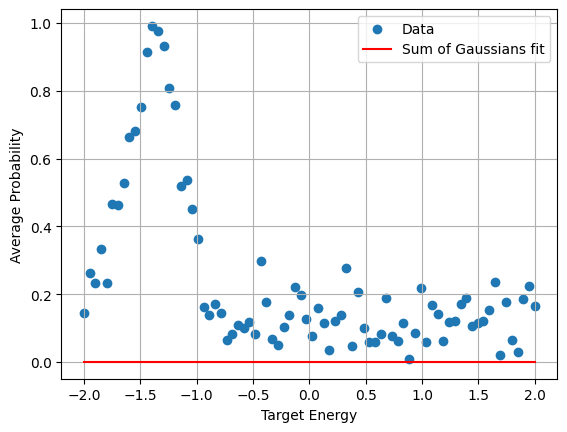

The peaks (centers) of the Gaussians are at: [-13.0]


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# This extracts the probabilities for the 0 bitcounts from our obtained data
values_list = []
for d in data:
    if 0 in d:
        values_list.append(d[0])
    else:
        values_list.append(0.0)
print(len(values_list))
print(len(targetenergies))

# Define a Gaussian function
def gaussian(x, amp, cen, wid):
    return amp * np.exp(-(x-cen)**2 / (2*wid**2))

# Define a sum of multiple Gaussians
def sum_of_gaussians(x, *params):
    n_gaussians = len(params) // 3
    result = np.zeros_like(x)
    for i in range(n_gaussians):
        amp = params[i*3]
        cen = params[i*3 + 1]
        wid = params[i*3 + 2]
        result += gaussian(x, amp, cen, wid)
    return result

# Initial guess for the parameters: amplitudes, centers, and widths of the Gaussians
initial_guess = [
    1, -13, 1
]

# Fit the sum of Gaussians to the data
popt, pcov = curve_fit(sum_of_gaussians, targetenergies, values_list, p0=initial_guess)

# Extract the fitted parameters
fitted_params = popt

# Generate x values for plotting the fit
x_fit = np.linspace(min(targetenergies), max(targetenergies), 1000)
y_fit = sum_of_gaussians(x_fit, *fitted_params)

# Plot the data and the fit
plt.scatter(targetenergies, values_list, label='Data')
plt.plot(x_fit, y_fit, color='red', label='Sum of Gaussians fit')
plt.grid()
plt.xlabel('Target Energy')
plt.ylabel('Average Probability')
#plt.axvline(x = -12.53, color = 'green', label = 'Ground State Energy')
plt.legend()
plt.show()

# Print the peaks (centers) of the Gaussians
n_gaussians = len(fitted_params) // 3
peaks = [fitted_params[i*3 + 1] for i in range(n_gaussians)]
print(f'The peaks (centers) of the Gaussians are at: {peaks}')